# Challenge 4 - Time Series Anomaly Detection with Auto ML

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.png)

As part of this challenge you will get familar with [AutoML SDK](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train) and use it's [timeseries forecasting](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-forecast) capabilities. We will use the forecasting capability to predict anomalies on a timeseries data. Relevant links will provided in the Notebook and help you to solve the tasks.

Generally a very good source of information is the [Python SDK reference](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/intro?view=azure-ml-py) for Azure Machine learning.

**Note:** In the Notebook altough there is no assigned tasks, you may see **<font color=red>???</font>** in various code blocks. Please fill them in, to successfully continue runnign the notebook. The purpose of those are to keep you engaging with the notebook and help you in learning the main [AutoML SDK](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train) commands.

## 1. Import Azure ML Python Python SDK

In [3]:
import azureml.core
print('SDK version:', azureml.core.VERSION)

SDK version: 1.12.0


*If the SDK verison is lower than the latest (1.12.0) please upgrade you AzureML SDK:*

In [ ]:
pip install --upgrade azureml-sdk

## 2. Authentication and initializing Azure Machine Learning Workspace
As a first step you have to authenticate against the Azure [Machine Learning Workspace](https://ml.azure.com/). This can be achieved in different ways:

1. **Interactive Login Authentication:** The interactive authentication is suitable for local experimentation on your own computer.
2. **Azure CLI Authentication:** Azure CLI authentication is suitable if you are already using Azure CLI for managing Azure resources, and want to sign in only once.
3. **Managed Service Identity (MSI) Authentication:** The MSI authentication is suitable for automated workflows, for example as part of Azure Devops build.
4. **Service Principal Authentication:** The Service Principal authentication is suitable for automated workflows, for example as part of Azure Devops build.

For now, we will use the interactive authentication, which is the default mode when using Azure ML SDK. When you connect to your workspace using `Workspace.from_config`, you will get an interactive login dialog.

In [4]:
from azureml.core import Workspace

ws = Workspace.from_config()
ws

Workspace.create(name='hack-prep-lili', subscription_id='757c4165-0823-49f7-9678-5a85fe5e17cc', resource_group='hack-prep-eli')

Note the user you're authenticated as must have access to the subscription and resource group. If you receive an error
```
AuthenticationException: You don't have access to xxxxxx-xxxx-xxx-xxx-xxxxxxxxxx subscription. All the subscriptions that you have access to = ...
```
check that the you used correct login and entered the correct subscription ID.

Alternatively, if you are using on premises Jupyter Notebooks you can also specify the details of your workspace.

In [ ]:
'''
# Alternative login method

from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication()

ws = Workspace(
    subscription_id='<your-subscription-id>',
    resource_group='<your-resource-group-name>',
    workspace_name='<your-workspace-name>',
    auth=interactive_auth
)
'''

## 3. Create an Experiment

You have already created an Azure ML `Workspace` object. For running Automated ML jobs you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [5]:
# choose a name for the run history container in the workspace
from azureml.core import Experiment
experiment_name = 'ch5-forecast-anomaly-automl'

experiment = Experiment(ws, experiment_name)

In [6]:
local_run=experiment.start_logging()

## 4. Working with Data

### 4.1. About  the NYC Energy Data

For this challenge we will be working with the  [Energy Demand data from New York City](http://mis.nyiso.com/public/P-58Blist.htm). We preprocessed the data for you, cleansed the mising information (The NYC Energy dataset is originally missing energy demand values for all datetimes later than August 10th, 2017 5AM), and seperated the data into test and train sets and added some obvious anomalies to the test set for the sake of visibility. 

The data is stored under the `dataset` directory in the `challenge_4` folder as two seperate csv's.

- **nyc_energy_train.csv**: containes the training data
- **nyc_energy_test.csv**: containes the test data with 2 artifical major and several original minor anomalies

Here is what we need to know about the dataset.

- **demand column** contains the Energy Demand information and it is what we want to forecast and detect anomalies. We will be marking this column as **target_column_name** . 

- **timeStamp column**  is the time axis of the data. Along this time axis we will forecast and detect anomalies.  We will be marking this column as **time_column_name** .

The other columns, **temp** and **precip**, are implicitly designated as features.


In [7]:
target_column_name = 'demand'
time_column_name = 'timeStamp'


Let's continue with the process of loading the data to the default datastore and registering their datasets.

### 4.2 Upload and Register the Data

Every workspace comes with a default [datastore](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-access-data) (and you can register more) which is backed by the Azure blob storage account associated with the workspace. We can use it to transfer data from local to the cloud, and create Dataset from it. We will now upload the Iris data to the default datastore (blob) within your workspace.

By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred.

In [8]:
# List all datastores registered in the current workspace
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore.datastore_type)

azureml_globaldatasets AzureBlob
workspacefilestore AzureFile
workspaceblobstore AzureBlob


For this challenge we will use the [default datastore](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-data#get-datastores-from-your-workspace) that comes with the Azure Machine Learning Workspace.

In [9]:
# get the default datastore
datastore = ws.get_default_datastore()
print(datastore.name, datastore.datastore_type, datastore.account_name, datastore.container_name, sep='\n')

workspaceblobstore
AzureBlob
hackpreplili7420074335
azureml-blobstore-d37c2f1a-0a6a-4f34-9136-5ba81d671f5b


**TASK:** upload the datatsets and create two tabular datasets suitable to use in time series operations. Fill in the missing code marked with **<font color='red'>???</font>** 

**Hint:** Make sure that the timeseries columns are acknowledged while loading the datasets. Check: [tabular dataset](https://docs.microsoft.com/bs-latn-ba/azure/machine-learning/service/how-to-create-register-datasets#dataset-types) ,[AutoML dataset methods](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py#methods)

First Upload the data to the default datastore

In [10]:
datastore.upload_files(
    files=['./dataset/nyc_energy_train.csv'],
    target_path='train_dataset/tabular/',
    overwrite=True,
    show_progress=True
)

datastore.upload_files(
    files=['./dataset/nyc_energy_test.csv'],
    target_path='train_dataset/tabular/',
    overwrite=True,
    show_progress=True
)

Uploading an estimated of 1 files
Uploading ./dataset/nyc_energy_train.csv
Uploaded ./dataset/nyc_energy_train.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Uploading an estimated of 1 files
Uploading ./dataset/nyc_energy_test.csv
Uploaded ./dataset/nyc_energy_test.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_266117ce822d4694bd94d0a3a949063f

Second, Create a Tabular Dataset:

In [11]:
from azureml.core import Dataset

train_dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'train_dataset/tabular/nyc_energy_train.csv')],
    validate=True,
    include_path=False,
    infer_column_types=True,
    set_column_types=None,
    separator=',',
    header=True,
    partition_format=None,
    support_multi_line=False,
    empty_as_string=False
).with_timestamp_columns(fine_grain_timestamp=time_column_name)

In [12]:
from azureml.core import Dataset

test_dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'train_dataset/tabular/nyc_energy_test.csv')],
    validate=True,
    include_path=False,
    infer_column_types=True,
    set_column_types=None,
    separator=',',
    header=True,
    partition_format=None,
    support_multi_line=False,
    empty_as_string=False
).with_timestamp_columns(fine_grain_timestamp=time_column_name)

Finally: Register The Dataset

In [13]:
train_dataset = train_dataset.register(
    workspace=ws,
    name='nyc_energy_train',
    description='NYC Energy Demand Time Series Data Train Set',
    create_new_version=True
)
train_dataset

{
  "source": [
    "('workspaceblobstore', 'train_dataset/tabular/nyc_energy_train.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "f766a7e8-d422-4210-ba6d-c5bc8fdf34f1",
    "name": "nyc_energy_train",
    "version": 1,
    "description": "NYC Energy Demand Time Series Data Train Set",
    "workspace": "Workspace.create(name='hack-prep-lili', subscription_id='757c4165-0823-49f7-9678-5a85fe5e17cc', resource_group='hack-prep-eli')"
  }
}

In [14]:
test_dataset = test_dataset.register(
    workspace=ws,
    name='nyc_energy_test',
    description='NYC Energy Demand Time Series Data Test Set',
    create_new_version=True
)
test_dataset

{
  "source": [
    "('workspaceblobstore', 'train_dataset/tabular/nyc_energy_test.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "fb87f65a-5c08-4bdf-bd22-5183fc75a206",
    "name": "nyc_energy_test",
    "version": 1,
    "description": "NYC Energy Demand Time Series Data Test Set",
    "workspace": "Workspace.create(name='hack-prep-lili', subscription_id='757c4165-0823-49f7-9678-5a85fe5e17cc', resource_group='hack-prep-eli')"
  }
}

Since we uploaded our data we can start building our compute instance.

## 5. Create or Attach existing AmlCompute
A compute target is required to execute a remote Automated ML run. 

[Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) is a managed-compute infrastructure that allows the user to easily create a single or multi-node compute. In this tutorial, you create AmlCompute as your training compute resource.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

**<font color=green> Here since the analysis we are running are more compute intensive, the compute clusters used on the previous challenges may not be performant and can take a longer time to train the models. therefore we are creating a cluster with a more superior Azure SKU</font>**

In [15]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "ch5cpucluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS13_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## 6. Time Series Operations:


### 6.1.  Forecasting Parameters

Forecasting the data and evaluating the deviation of the actuals from the forecast is a widely used technique to detect anomalies in Time Seried datasets. 

For this challenge we will utilise [AutoML's time series forecasting capabilities](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-forecast) to detect anomalies in NY Energy dataset.

Let's go through the necessary parameters that needs to be defined to male an Auto ML time series forecasting call.


To define forecasting parameters for your experiment training, you can leverage the ForecastingParameters class. The table below details the forecasting parameter we will be passing into our experiment.

|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|

The **forecast horizon** is the number of periods into the future that the model should predict. It is generally recommended that users set forecast horizons to less than 100 time periods (i.e. less than 100 hours in the NYC energy example). Furthermore, **AutoML's memory use and computation time increase in proportion to the length of the horizon**, so consider carefully how this value is set. If a long horizon forecast really is necessary, consider aggregating the series to a coarser time scale. 

Learn more about forecast horizons in our [Auto-train a time-series forecast model](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-auto-train-forecast#configure-and-run-experiment) guide.

In this example, we will set the horizon to 48 hours.

In [18]:
forecast_horizon = 48

### 6.3. Automl Configuration

Instantiate an AutoMLConfig object. This config defines the settings and data used to run the experiment. We can provide extra configurations within 'automl_settings', for this forecasting task we add the forecasting parameters to hold all the additional forecasting parameters.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**blocked_models**|Models in blocked_models won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.forecasting?view=azure-ml-py).|
|**experiment_timeout_hours**|Maximum amount of time in hours that the experiment take before it terminates.|
|**training_data**|The training data to be used within the experiment.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits. Rolling Origin Validation is used to split time-series in a temporally consistent way.|
|**enable_early_stopping**|Flag to enble early termination if the score is not improving in the short term.|
|**forecasting_parameters**|A class holds all the forecasting related parameters.|


**Task:** Instantiate an AutoMLConfig object for the forecasting purpose of our training dataset.

**Hint 1:** [AutoML forecast configuration settings](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-forecast#configuration-settings)

**Hint 2:** Using the **blocked_models** parameter to exclude some models like ***'ExtremeRandomTrees', 'AutoArima', 'Prophet'*** that take a longer time to train on this dataset, this can improve your run durations. You can choose to remove models from the blocked_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

In [19]:
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name, 
    forecast_horizon=forecast_horizon
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',#'normalized_mean_absolute_error'
                             blocked_models = ['ExtremeRandomTrees', 'AutoArima', 'Prophet'],                             
                             experiment_timeout_hours=1,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             max_cores_per_iteration=-1,
                             forecasting_parameters=forecasting_parameters)

## 7. Train the Model

You dont need to create a training script to train an AutoML model. You can directly call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.

**Task:** Call the `submit` method on the experiment object and pass the run configuration.

**Hint:** One may specify `show_output = True` to print currently running iterations to the console.

In [20]:
remote_run = experiment.submit(automl_config, show_output=False)

Running on remote or ADB.



**Task:** View the the `remote_run` object and call the required methods to follow the status.

**Hint:** [wait-for-completion](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py#wait-for-completion-show-output-false--wait-post-processing-false--raise-on-error-true-)
**ADD the widget**

In [21]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
ch5-forecast-anomaly-automl,AutoML_73766ac7-a493-41bb-8e72-e380124c4a98,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [22]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [23]:
remote_run.wait_for_completion()

{'runId': 'AutoML_73766ac7-a493-41bb-8e72-e380124c4a98',
 'target': 'ch5cpucluster',
 'status': 'Completed',
 'startTimeUtc': '2020-09-01T16:26:12.71272Z',
 'endTimeUtc': '2020-09-01T16:58:39.490936Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'ch5cpucluster',
  'AMLSettingsJsonString': '{"path":null,"name":"ch5-forecast-anomaly-automl","subscription_id":"757c4165-0823-49f7-9678-5a85fe5e17cc","resource_group":"hack-prep-eli","workspace_name":"hack-prep-lili","region":"northeurope","compute_target":"ch5cpucluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_mi

## 8. Retrieve the Best Model
**Task:** Select the best model from all the training iterations using get_output method of 'remote_run' object.

In [24]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('0', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=0.8,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples...  min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'))]))],
                 flatten_transform=None,
                 weights=[0.4666666666666667, 0.2, 0.13333333333333333, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]))]

## 9. Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:



In [25]:
X_test = test_dataset.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

### 9.1 Forecast Function
For forecasting, we will use the forecast function instead of the predict function. Using the predict method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use. Forecast function also can handle more complicated scenarios, see the [forecast function notebook](../forecasting-forecast-function/auto-ml-forecasting-function.ipynb).

**Task:** Forecast the test set

In [26]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

### 9.2 Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

Below we are using the forecasting_helper.py existing in the same directory with our notebook to combine the datasets easly:


In [27]:
from forecasting_helper  import align_outputs 

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

In [28]:
os.listdir()

['.azureml',
 '.config',
 '.ipynb_checkpoints',
 'automl.log',
 'azureml_automl.log',
 'challenge_4_solution.ipynb',
 'dataset',
 'forecasting_helper.py',
 'model.pkl',
 'outputs',
 '__pycache__']

**Task:** Retrieve Scores for the best model

**Hint:** [azureml.automl.runtime.shared.score.scoring](https://docs.microsoft.com/en-us/python/api/azureml-automl-runtime/azureml.automl.runtime.shared.score.scoring?view=azure-ml-py)

In [29]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring


# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    

[Test data scores]

mean_absolute_percentage_error:   7.654
explained_variance:   0.319
r2_score:   0.277
spearman_correlation:   0.828
normalized_median_absolute_error:   0.054
root_mean_squared_error:   897.217
normalized_mean_absolute_error:   0.098
root_mean_squared_log_error:   0.139
median_absolute_error:   285.776
mean_absolute_error:   514.731
normalized_root_mean_squared_log_error:   0.163
normalized_root_mean_squared_error:   0.170


**Task:** Plot the test sets Actuals and Predictions to visualy examine the datasets. ick your anomally candidates from the Actual data.

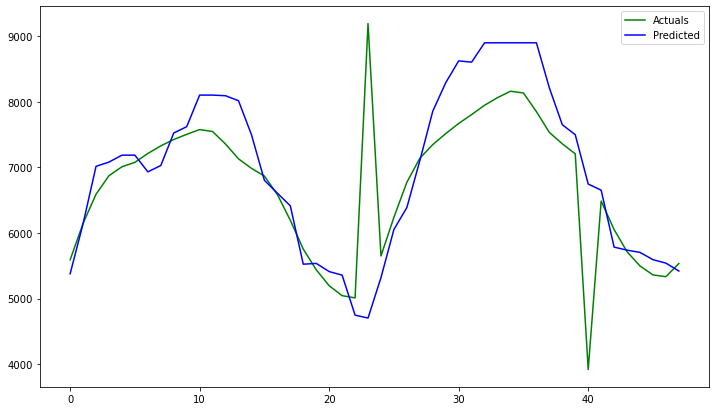

<Figure size 432x288 with 0 Axes>

In [30]:
from matplotlib import pyplot as plt
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.plot(df_all[target_column_name], color='green',label='Actuals')
plt.plot(df_all['predicted'], color='blue',label='Predicted')
plt.legend(loc='upper right')
plt.show()

local_run.log_image(name='Graph of Aztuals vs Predicted Data', plot=plt)

## 10. Detect the anomalies

To detect the anomalies we need to decide what our normal and anormal date looks like. There are several ways to identify these boundaries.

 a. Check whether the absolute error is bigger than [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)
 
 b. Calculate a moving average of the error check wheter the actual error is within
 
 c. Adjust the moving average with dataset median error to reduce the effect of anomalies in the normal data boundry.
 
 Below function does the item c.  run ad check the results.
 
 **Bonus Task:** Implement MAPE techique with the same way.

In [31]:
import numpy as np
def detect_classify_anomalies(df,target_column_name,window,med_abs_error):
    def check_boundary (x,ub,lb):
        if (x>ub or x<lb):
            val=x
        else:
            val=np.nan
        return val
   
    df['abserror']=abs(df[target_column_name]-df['predicted'])
    df['rel_error'] = (df['abserror'].rolling(window=window).sum().fillna(med_abs_error)+med_abs_error)/(window+1)
    df['upper']=(df['predicted']+df['rel_error']*1.5)
    df['lower']=(df['predicted']-df['rel_error']*1.5)
    df['anomaly'] = df.apply(lambda x: check_boundary(x[target_column_name],x["upper"],x["lower"]),axis=1)
  
    return df

In [32]:
df_all=detect_classify_anomalies(df_all,target_column_name,4,scores['median_absolute_error'])

**TASK:** Plot the test sets Actuals , Predictions,Anomaly boundaries and anomalies  to visualy examine the datasets. Check whether the anomalies you visiauly picked at the previous excersize are marked as anomalies.

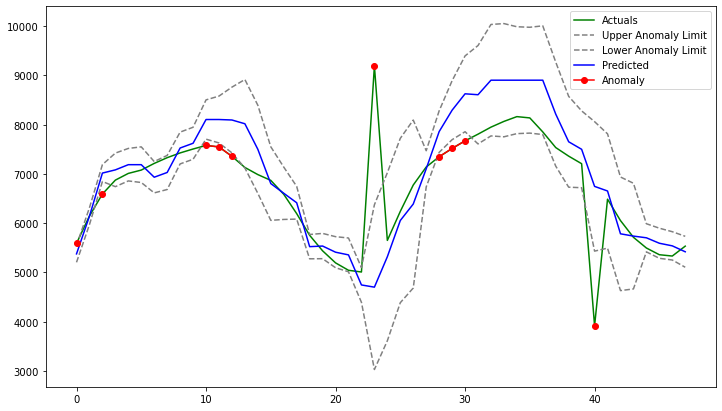

<Figure size 432x288 with 0 Axes>

In [33]:
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.plot(df_all[target_column_name], color='green',label='Actuals')
plt.plot(df_all['upper'], color='gray', linestyle='dashed', label='Upper Anomaly Limit')
plt.plot(df_all['lower'], color='gray', linestyle='dashed', label='Lower Anomaly Limit')
plt.plot(df_all['predicted'], color='blue',label='Predicted')
plt.plot(df_all['anomaly'] , color='red', marker='o',label='Anomaly')
plt.legend(loc='upper right')
plt.show()


local_run.log_image(name='Graph of Actuals vs Predicted with Anomalies and Anomaly Boundaries', plot=plt)

**In this challenge we performed some tasks locally and manually and some other tasks remotely via AutoML. on the next challenge you will see how you can create pipelines to orchestrate and manage these seperate tasks**